## Load the Data

In [1]:
import json
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, recall_score
# import math

# Load JSON data
with open('./training-set/result.json', 'r') as f:
    data = json.load(f)

# Initialize lists to store features and labels
X = []
y = []

## Helper Functions

In [2]:
# Define function to load and preprocess images
def preprocess_image(image_path, bbox):
    image = cv2.imread(image_path)
    # Resize image if needed
    # image = cv2.resize(image, (desired_width, desired_height))
    # Extract region of interest using bounding box
    x, y, w, h = [int(x) for x in bbox]
    # print(bbox)
    roi = image[y:y+h, x:x+w]
    # Perform any additional preprocessing if needed
    # ...
    # Return preprocessed image
    return roi

def extract_features_CNN(image):
    import numpy as np
    from keras.applications.vgg16 import VGG16, preprocess_input
    from keras.preprocessing import image as Image
    # Load pre-trained VGG16 model
    model = VGG16(weights='imagenet', include_top=False)
    
    # Resize image to the input size expected by VGG16
    input_shape = (224, 224)
    resized_image = cv2.resize(image, input_shape)
    
    # Preprocess input image
    preprocessed_image = preprocess_input(resized_image)
    
    # Expand dimensions to match the input shape expected by the model
    preprocessed_image = np.expand_dims(preprocessed_image, axis=0)
    
    # Extract features using the pre-trained model
    features = model.predict(preprocessed_image)

    
    # Flatten the features to create a feature vector
    feature_vector = features.flatten()
    
    return feature_vector

def extract_features(image):
    hist = cv2.calcHist([image], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    hist = cv2.normalize(hist, hist).flatten()  # Normalize and flatten the histogram
    return hist

def augment_image(image):
    augmented_images = []
    
    # # Flip horizontally -> mirror image doesn't make sense here for question and answer type datasets
    # flipped_image = np.flip(image, 1)
    # augmented_images.append(flipped_image)

    # Flip vertically
    flipped_image = np.flip(image, 0)
    augmented_images.append(flipped_image)
    
    # Rotate image by 90 degrees
    rotated_image = np.rot90(image)
    augmented_images.append(rotated_image)
    
    # # Rotate image by 15 degrees

    from scipy.ndimage import rotate
    rotated_image = rotate(image, angle=15, reshape=False)
    augmented_images.append(rotated_image)

    rotated_image = rotate(image, angle=-15, reshape=False)
    augmented_images.append(rotated_image)
    
    return augmented_images


## Data abstraction

In [3]:
# Iterate through annotations to extract features and labels
for annotation in data['annotations']:
    image_id = annotation['image_id']
    category_id = annotation['category_id']
    bbox = annotation['bbox']
    image_info = data['images'][image_id]
    image_path = os.path.join(os.getcwd(),'training-set', image_info['file_name'])
    
    # Load and preprocess image
    image = preprocess_image(image_path, bbox)
    
    # Extract features using pre-trained CNN model
    # feature_vector = extract_features(image)

    # Load and preprocess image
    image = cv2.imread(image_path)
    a, b, w, h = [int(x) for x in bbox]
    roi = image[b:b+h, a:a+w]

    # extracting features
    feature_vector = extract_features(roi)
    
    # feature_vector = np.random.rand(1000)
    
    # Append feature vector to X
    X.append(feature_vector)
    
    # Append category label to y
    y.append(category_id)

    # Data Augmentation Part
    for aug_image in augment_image(roi):
        feature_vector = extract_features(aug_image)
        X.append(feature_vector)
        y.append(category_id)


# Convert lists to numpy arrays
X = np.array(X)
y = np.array(y)

## Training and Testing

In [6]:

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize logistic regression model

# logistic_reg = LogisticRegression(max_iter=5000)

# n_estimators_list = [570,585] ->570 max

# for n in range(n_estimators_list):
randomForest = RandomForestClassifier(n_estimators=570, random_state=42)

# Train the model
randomForest.fit(X_train, y_train)

import joblib
# Save the trained model
joblib.dump(randomForest, 'random_forest_model.pkl')

['random_forest_model.pkl']

In [7]:
y_pred = randomForest.predict(X_test)

f1 = f1_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
# Evaluate the model
accuracy = randomForest.score(X_test, y_test)
print("Accuracy:", accuracy)
print("F1:", f1)
print("Recall:", recall)

Accuracy: 0.9501385041551247
F1: 0.9501354429374679
Recall: 0.9501385041551247


## Metrics

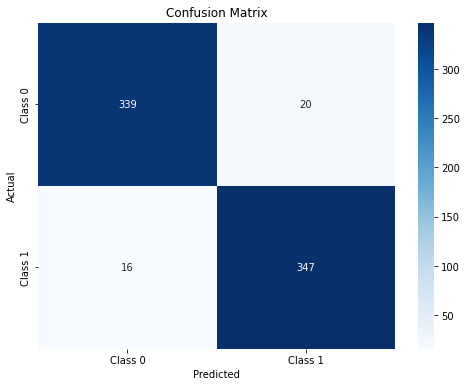

In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()